In [2]:
import numpy as np
import optuna
import pandas as pd
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, \
    median_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [3]:
df = pd.read_parquet('../data/data_with_meteo.parquet')

In [4]:
df['duedate'] = pd.to_datetime(df['duedate'])
df['hour'] = df['duedate'].dt.hour
df['dayofweek'] = df['duedate'].dt.dayofweek  # 0=lundi
df['is_weekend'] = df['dayofweek'] >= 5


In [5]:
y_columns = ['numdocksavailable', 'numbikesavailable']
X_columns = df.columns.difference(y_columns + ['coordonnees_geo', 'duedate'])
X = df[X_columns]
y = df['numdocksavailable']

split_date = "2025-12-20"

# Features
X_train = df.loc[df["duedate"] < split_date, X_columns]
X_val  = df.loc[df["duedate"] >= split_date, X_columns]

# Target
y_train = df.loc[df["duedate"] < split_date, y_columns]
y_val  = df.loc[df["duedate"] >= split_date, y_columns]

In [28]:
def build_preprocessor(X: pd.DataFrame):
    numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
    categorical_features = X.select_dtypes(include=["object", "category"]).columns

    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ('scaler', StandardScaler()),
        ]
    )

    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )

    return preprocessor


In [29]:
def build_model():
    return CatBoostRegressor(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        loss_function="RMSE",
        verbose=False,
        random_seed=42
    )

In [30]:
def objective(trial):
    params = {
        "loss_function": "MultiRMSE",
        "iterations": trial.suggest_int("iterations", 100, 1000, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 50.0, log=True),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20),
        "max_ctr_complexity": trial.suggest_int("max_ctr_complexity", 2, 4),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "random_strength": trial.suggest_float("random_strength", 0.0, 2.0),
        "early_stopping_rounds": 50,
        "task_type": "CPU",
        "random_seed": 42,
        "verbose": False
    }

    model = CatBoostRegressor(**params)
    pipeline = Pipeline(
        steps=[
            ("preprocessor", build_preprocessor(X_train)),
            ("model", model)
        ]
    )

    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_val)
    return r2_score(y_val, preds)

In [31]:
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42)
)

study.optimize(
    objective,
    n_trials=50,       # 50–100 recommandé en fonction de la performance de la machine
    timeout=None,
    n_jobs=1
)

[I 2025-12-25 18:47:27,339] A new study created in memory with name: no-name-80d5ec70-1cf4-4284-973a-93a2f5ccece4
[I 2025-12-25 18:48:05,175] Trial 0 finished with value: 0.9938174196082123 and parameters: {'iterations': 236, 'learning_rate': 0.08927180304353628, 'depth': 9, 'l2_leaf_reg': 10.401663679887308, 'one_hot_max_size': 4, 'max_ctr_complexity': 2, 'bagging_temperature': 0.05808361216819946, 'random_strength': 1.7323522915498704}. Best is trial 0 with value: 0.9938174196082123.
[I 2025-12-25 18:48:26,046] Trial 1 finished with value: 0.9903479649246552 and parameters: {'iterations': 398, 'learning_rate': 0.051059032093947576, 'depth': 4, 'l2_leaf_reg': 44.447541666908116, 'one_hot_max_size': 17, 'max_ctr_complexity': 2, 'bagging_temperature': 0.18182496720710062, 'random_strength': 0.36680901970686763}. Best is trial 1 with value: 0.9903479649246552.
[I 2025-12-25 18:48:52,232] Trial 2 finished with value: 0.9899043239272359 and parameters: {'iterations': 201, 'learning_rate': 

In [33]:
print("Best score:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")

Best score: 0.7970659120860393
Best params:
iterations: 100
learning_rate: 0.010058413471614472
depth: 7
l2_leaf_reg: 6.262527608310153
one_hot_max_size: 2
max_ctr_complexity: 4
bagging_temperature: 0.5467026508424057
random_strength: 0.009730198756902508


In [34]:
best_params = study.best_params

model = CatBoostRegressor(
    **best_params,
    loss_function="MultiRMSE",
    task_type="CPU",
    random_seed=42,
    verbose=10
)

In [35]:
pipeline = Pipeline(
    steps=[
        ('preprocessor', build_preprocessor(X_train)),
        ('model', model)
    ]
)

pipeline.fit(X_train, y_train)

0:	learn: 16.6987481	total: 30.5ms	remaining: 3.02s
10:	learn: 15.3559421	total: 406ms	remaining: 3.28s
20:	learn: 14.1490773	total: 787ms	remaining: 2.96s
30:	learn: 13.0517872	total: 1.17s	remaining: 2.61s
40:	learn: 12.0565062	total: 1.56s	remaining: 2.25s
50:	learn: 11.1504844	total: 1.95s	remaining: 1.87s
60:	learn: 10.3293280	total: 2.28s	remaining: 1.46s
70:	learn: 9.5807420	total: 2.64s	remaining: 1.08s
80:	learn: 8.8976739	total: 2.98s	remaining: 700ms
90:	learn: 8.2778763	total: 3.33s	remaining: 330ms
99:	learn: 7.7684814	total: 3.82s	remaining: 0us


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [36]:
y_pred = pipeline.predict(X_val)

print(f'R2 score: {r2_score(y_val, y_pred)}')
print(f'Mean squared error: {mean_squared_error(y_val, y_pred)}')
print(f'Mean absolute error: {mean_absolute_error(y_val, y_pred)}')
print(f'Root mean squared error: {np.sqrt(mean_squared_error(y_val, y_pred))}')
print(f'Median of absolute error: {median_absolute_error(y_val, y_pred)}')

R2 score: 0.7970659120860393
Mean squared error: 25.799396489802774
Mean absolute error: 3.7008405566640716
Root mean squared error: 5.079310631355674
Median of absolute error: 2.846573900816629


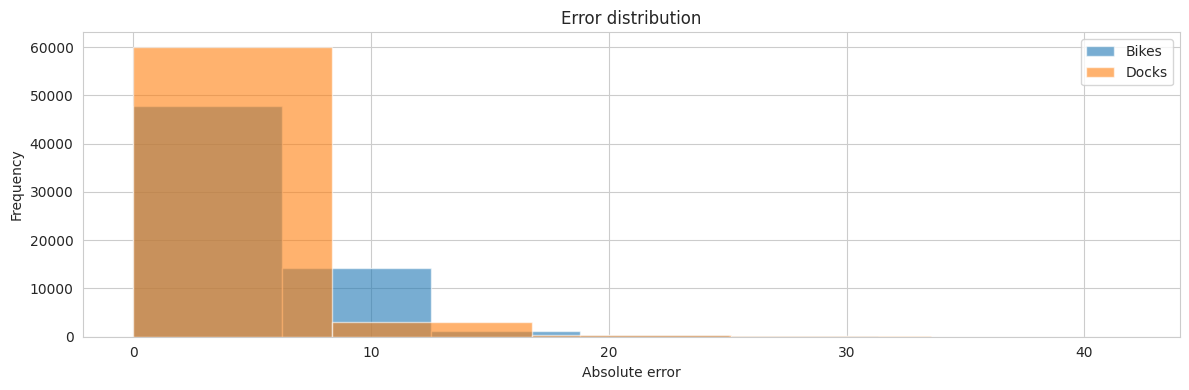

In [37]:
error = np.abs(y_val - y_pred)   # shape: (n_samples, 2)
plt.figure(figsize=(12, 4))

plt.hist(error['numdocksavailable'], bins=5, alpha=0.6, label="Bikes")
plt.hist(error['numbikesavailable'], bins=5, alpha=0.6, label="Docks")

plt.xlabel("Absolute error")
plt.ylabel("Frequency")
plt.title("Error distribution")
plt.legend()
plt.tight_layout()
plt.show()